## Exploratory data analysis: PCA and Mahalanobis distance analysis
**Author:** Y.X. Wu

This notebook aims to conduct a comparative analysis between our new data set and existing literature data set based on two properties: hardness and corrosion. Both data sets have a defined compositional feature space. The new data set, however, is generated in a different regime of the compositional feature space.

The purpose of the analysis is twofold:

* **Principal Component Analysis (PCA)**: We'll use PCA as a technique to reduce the dimensionality of the feature space. It will allow us to effectively visualize the new data alongside the literature data within the same reduced feature space. PCA does this by transforming the original variables into a new set of uncorrelated variables called principal components, which are ordered by the amount of variance they can explain from the original data. This allows us to capture most of the information in the original data with fewer dimensions.

* **Mahalanobis Distance Calculation**: Following the visualization, we'll take a more in-depth look into the data by calculating the Mahalanobis distance for all the new data points from the centroid of the literature data set. The Mahalanobis distance is a measure of the distance between a point and a distribution, not between two distinct points. It's effectively a multivariate equivalent of the Euclidean distance. However, unlike Euclidean distance, the Mahalanobis distance is scale-invariant and takes into account the correlations of the data set. By calculating the Mahalanobis distance, we can quantify how much the new data deviates from the distribution of the literature data.

In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import math 
import matplotlib.cm as cm
import matplotlib as mpl
import os

# display the current working directory
display("Current working directory: {0}".format(os.getcwd()))

data_path = '../Dataset_Cleaned/'
display(os.path.isfile(data_path+'Hardness_database_YW_v3.xlsx'))

'Current working directory: /nethome/yuxiang.wu/CCA-representation-ML/Dataset_EDA_Pairplot_PCA_Mahalanobis'

True

### Import hardness and corrosion LITERATURE datasets 

In [3]:
# Define column names for the composition dataframe
column_names_H = ['Fe', 'Cr', 'Ni', 'Mo', 'W', 'N', 'Nb', 'C', 'Si', 'Mn', 'Cu', 'Al', 'V', 'Ta', 'Ti', 'Co', 'Mg', 'Y', 'Zr', 'Hf']
column_names_C = ['Fe', 'Cr', 'Ni', 'Mo', 'W', 'N', 'Nb', 'C', 'Si', 'Mn', 'Cu', 'Al', 'V', 'Ta', 'Ti', 'Co', 'Mg', 'Y']

# Import the Hardness dataset, starting from the third row (header=2) because the first two rows are presumably not relevant
df_H = pd.read_excel(data_path + 'Hardness_database_YW_v3.xlsx', header=2)

# Extract relevant columns from the Hardness dataframe, and fill in any missing values with zero
df_H_compo = df_H[column_names_H].fillna(0)
 
# Import the Corrosion dataset, starting from the third row (header=2) because the first two rows are presumably not relevant
df_C = pd.read_excel(data_path + 'Corrosion_database_YW_v3.xlsx', header=2)

# Extract relevant columns from the Corrosion dataframe, and fill in any missing values with zero
df_C_compo = df_C[column_names_C].fillna(0)

# Display the first row of both dataframes
display(df_H_compo.head(1), df_H_compo.shape,
        df_C_compo.head(1), df_C_compo.shape)  

,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,Cu,Al,V,Ta,Ti,Co,Mg,Y,Zr,Hf
0,19.92,18.54,20.93,0.0,0.0,0,0.0,0.0,0.0,19.59,0.0,0.0,0.0,0.0,0.0,21.02,0,0.0,0.0,0.0


(680, 20)

,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,Cu,Al,V,Ta,Ti,Co,Mg,Y
0,69.77,18.0,10.0,0.0,0.0,0.0,0.0,0.03,1.0,1.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(712, 18)

### Import NEW dataset

In [4]:
# Define relevant columns for each dataframe
columns_FeCrNiMoTi = ['Fe', 'Cr', 'Ni', 'Mo', 'Ti']
columns_FeCrNiCoV  = ['Fe', 'Cr', 'Ni', 'Co', 'V']

# Import each dataset, select relevant columns, and fill NaN values with zero
df_compo_new_FeCrNiMoTi = pd.read_excel(data_path + 'MultiTaskModel_NiCrMoTiFe_KW131_wt_pct.xlsx')[columns_FeCrNiMoTi].fillna(0)
df_compo_new_FeCrNiCoV  = pd.read_excel(data_path + 'MultiTaskModel_NiCrCoVFe_KW99_wt_pct.xlsx')[columns_FeCrNiCoV].fillna(0)

# Display the first row of both dataframes
display(df_compo_new_FeCrNiMoTi.head(1))
display(df_compo_new_FeCrNiCoV.head(1))


,Fe,Cr,Ni,Mo,Ti
0,14.316994,35.210247,45.453038,4.138939,0.880782


,Fe,Cr,Ni,Co,V
0,10.271486,31.290494,51.985556,4.851446,1.601018


### Datasets labelling for both datasets and concatenation

In [5]:
# Assign 'dataset' values in Corrosion and Hardness dataframes
for df, label in zip([df_C_compo, df_H_compo, df_compo_new_FeCrNiMoTi, df_compo_new_FeCrNiCoV], 
                     ['corrosion dataset', 'hardness dataset', 'new FeCrNiMoTi', 'new FeCrNiCoV']):
    df['dataset'] = label

# Concatenate dataframes, export to Excel, and display results
df_conc = pd.concat([df_C_compo, df_H_compo], ignore_index=True).fillna(0)
df_conc.to_excel('pairplot_corrosion_hardness_datasets.xlsx')
display(df_conc.iloc[[0, 1, -2, -1]], df_conc.shape)

,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,...,Al,V,Ta,Ti,Co,Mg,Y,dataset,Zr,Hf
0,69.77,18.00,10.00,0.00,0.0,0.0,0.0,0.03,1.0,1.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,corrosion dataset,0.0,0.0
1,69.77,18.00,10.00,0.00,0.0,0.0,0.0,0.03,1.0,1.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,corrosion dataset,0.0,0.0
1390,21.72,20.23,22.83,0.00,0.0,0.0,0.0,0.00,0.0,0.0,...,10.5,0.0,0.0,0.0,0.00,0.0,0.0,hardness dataset,0.0,0.0
1391,20.17,0.00,42.40,6.93,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,9.2,0.0,0.0,21.29,0.0,0.0,hardness dataset,0.0,0.0


(1392, 21)

### assign literature vs new datasets

In [6]:
# Function to process and concatenate DataFrame details
def process_df(df, dataset_name, df_conc):
    return pd.concat([df_conc, df.assign(dataset=dataset_name)], ignore_index=True).fillna(0)

# Concatenate and preprocess data
df_conc_new_FeCrNiMoTi = process_df(df_compo_new_FeCrNiMoTi, 'new FeCrNiMoTi', df_conc)
df_conc_new_FeCrNiCoV = process_df(df_compo_new_FeCrNiCoV, 'new FeCrNiCoV', df_conc)

# Concatenate both new datasets and remove duplicates
df_conc_new = pd.concat([df_conc, 
                         df_compo_new_FeCrNiMoTi,
                         df_compo_new_FeCrNiCoV], 
                         ignore_index=True).fillna(0)

display(df_conc_new.shape)

# Display the desired data
for df in [df_conc_new_FeCrNiMoTi, df_conc_new_FeCrNiCoV]:
    display(df.iloc[[0, -71, -2, -1]], df.shape)


(1530, 21)

,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,...,Al,V,Ta,Ti,Co,Mg,Y,dataset,Zr,Hf
0,69.770000,18.000000,10.000000,0.000000,0.0,0.0,0.0,0.03,1.0,1.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,corrosion dataset,0.0,0.0
1390,21.720000,20.230000,22.830000,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,...,10.5,0.0,0.0,0.000000,0.0,0.0,0.0,hardness dataset,0.0,0.0
1459,65.324524,4.818151,24.401985,2.839441,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,2.615900,0.0,0.0,0.0,new FeCrNiMoTi,0.0,0.0
1460,63.370312,5.076982,23.439965,4.034033,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,4.078709,0.0,0.0,0.0,new FeCrNiMoTi,0.0,0.0


(1461, 21)

,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,...,Al,V,Ta,Ti,Co,Mg,Y,dataset,Zr,Hf
0,69.770000,18.000000,10.000000,0.0,0.0,0.0,0.0,0.03,1.0,1.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,corrosion dataset,0.0,0.0
1390,21.720000,20.230000,22.830000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,10.5,0.000000,0.0,0.0,0.000000,0.0,0.0,hardness dataset,0.0,0.0
1459,54.187698,5.396440,32.543752,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,5.431837,0.0,0.0,2.440272,0.0,0.0,new FeCrNiCoV,0.0,0.0
1460,51.347188,5.827793,31.584854,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,8.142295,0.0,0.0,3.097870,0.0,0.0,new FeCrNiCoV,0.0,0.0


(1461, 21)

### Pairplots: the new datasets in relation to hardness and corrosion literatrue datasets

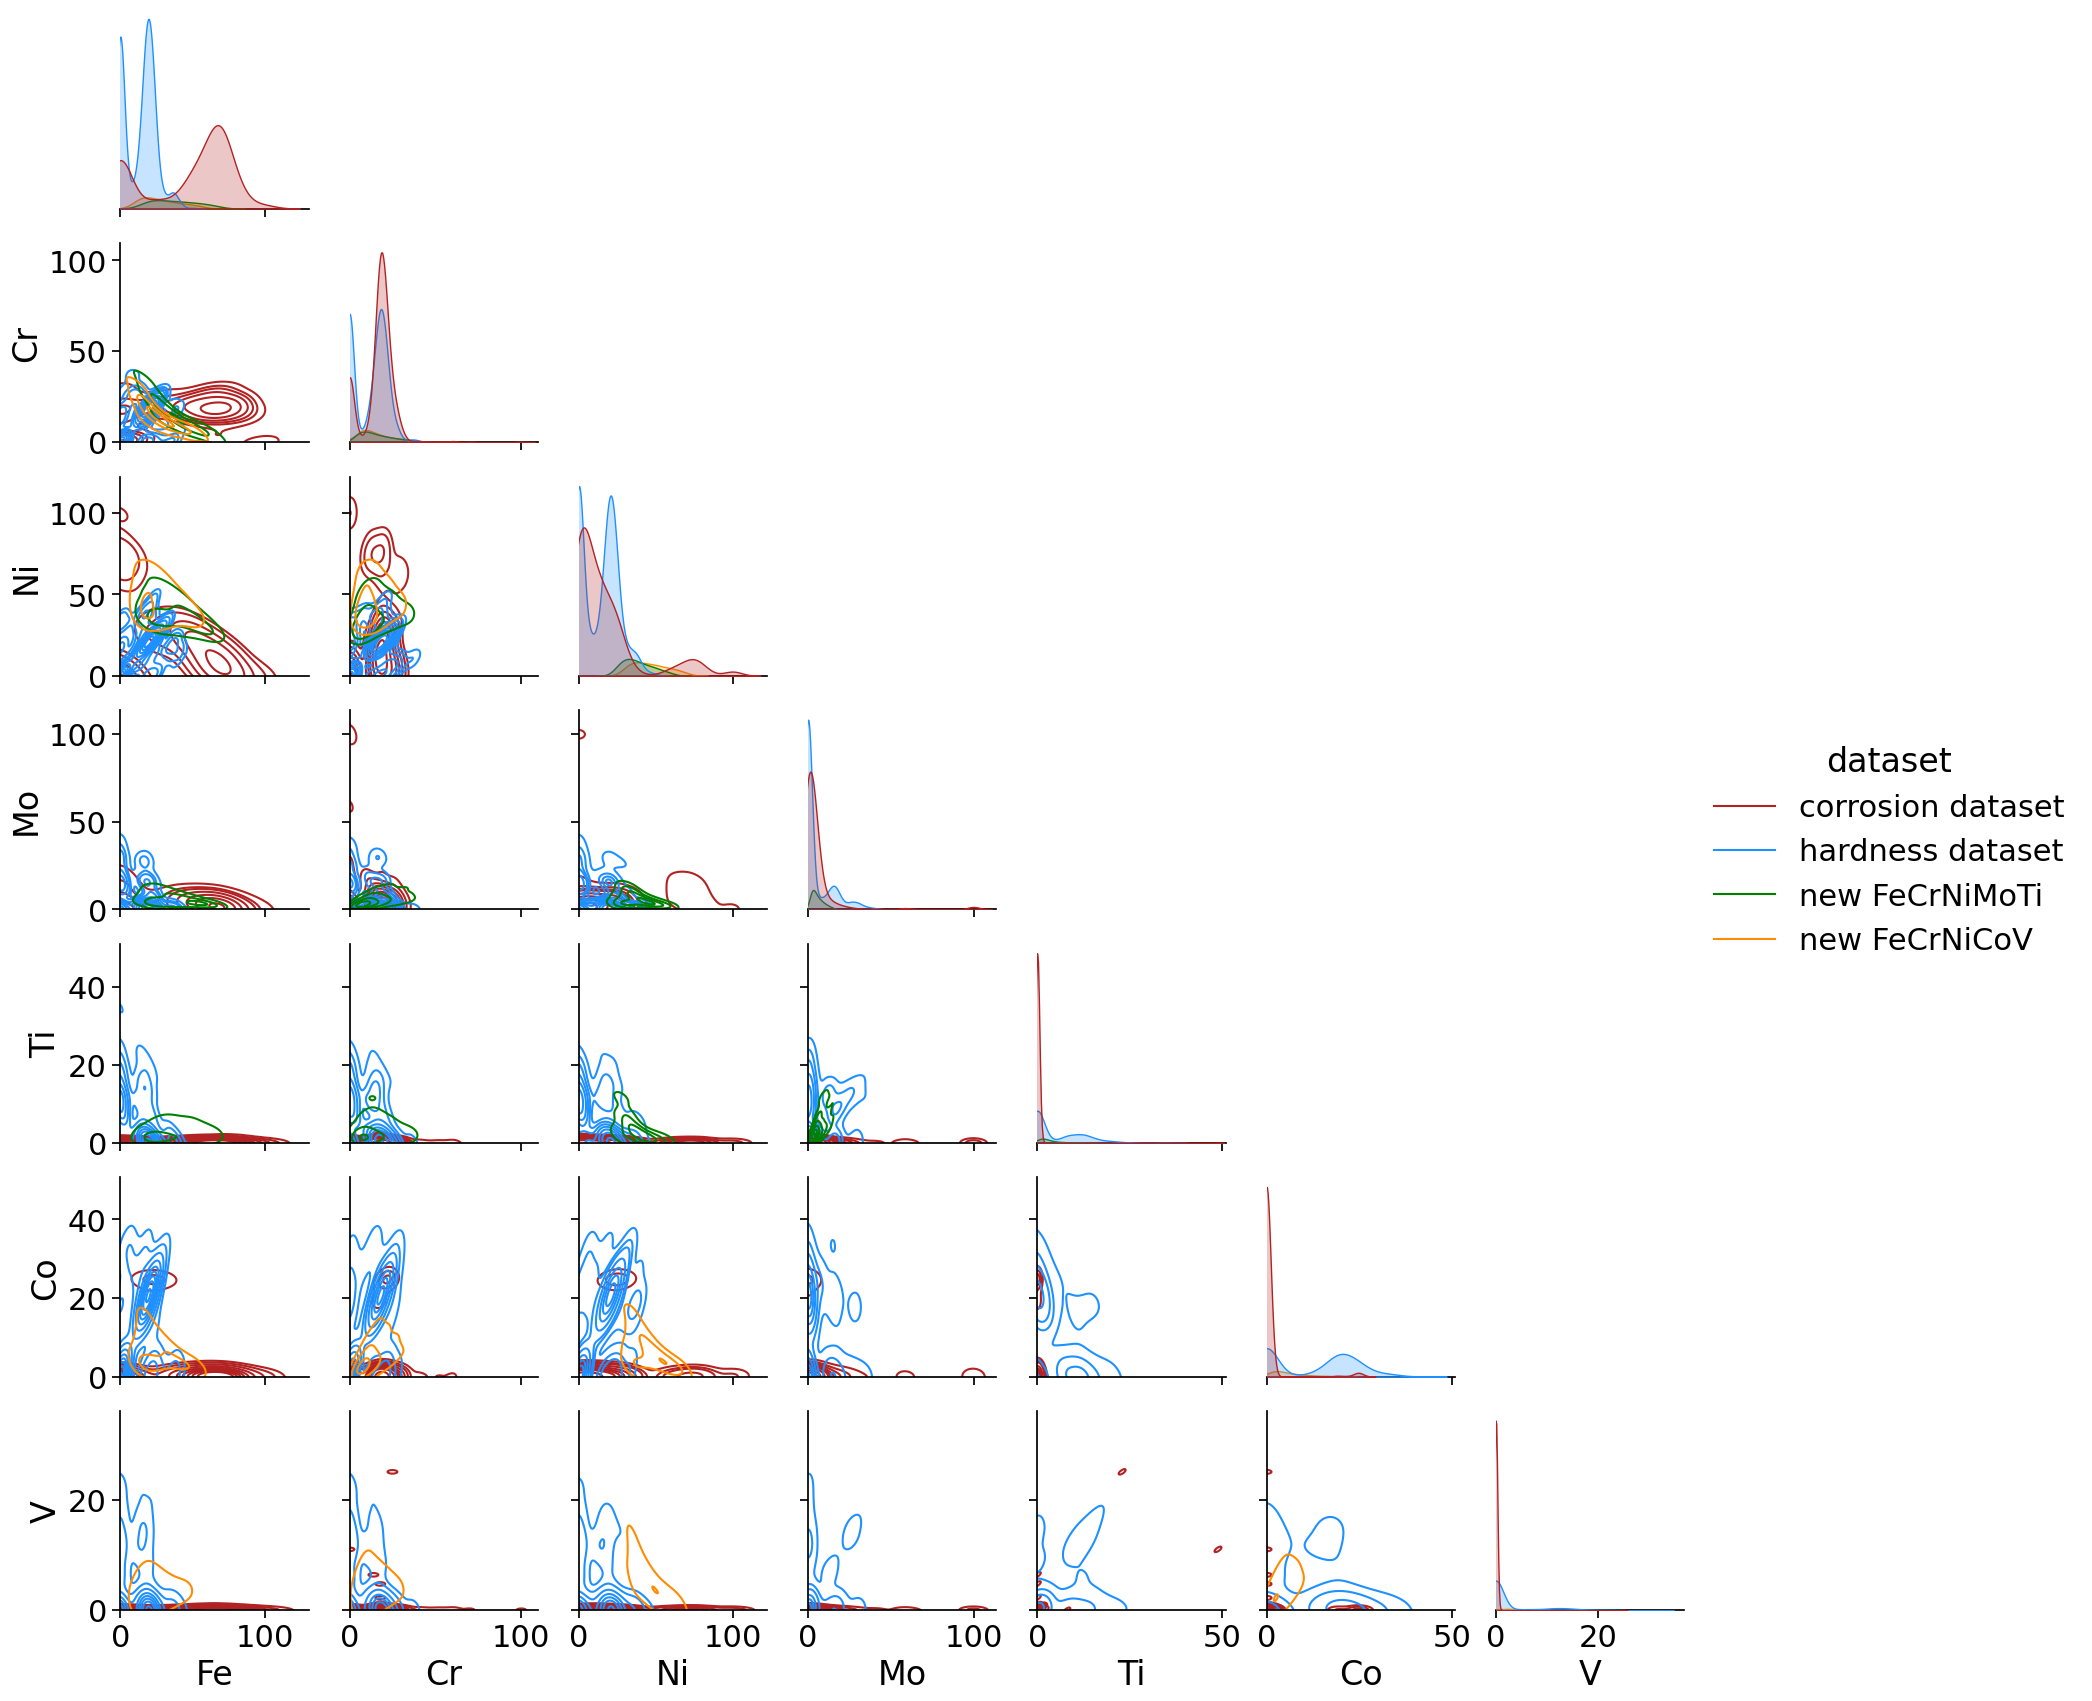

In [7]:
sns.set_context("notebook", font_scale=2)

# Define color palette for the pairplot
palette = ["firebrick", "dodgerblue", "green", "darkorange"]

# Create pairplot with KDE for all data
grid_kde = sns.pairplot(df_conc_new, vars=['Fe', 'Cr', 'Ni', 'Mo', 'Ti', 'Co', 'V'], 
                        hue="dataset", kind="kde", corner=True, palette=palette)

# Adjust x and y limits using list comprehension
_ = [[ax.set_xlim(left=0), ax.set_ylim(bottom=0)] for ax_row in grid_kde.axes for ax in ax_row if ax is not None]

plt.savefig('pairplot_literature+new.png', bbox_inches='tight')

# Show the plots
plt.show()


### Now let's try PCA
https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html#sphx-glr-auto-examples-decomposition-plot-pca-vs-lda-py

Explained variance ratio (first two components): [0.39299539 0.21353582]


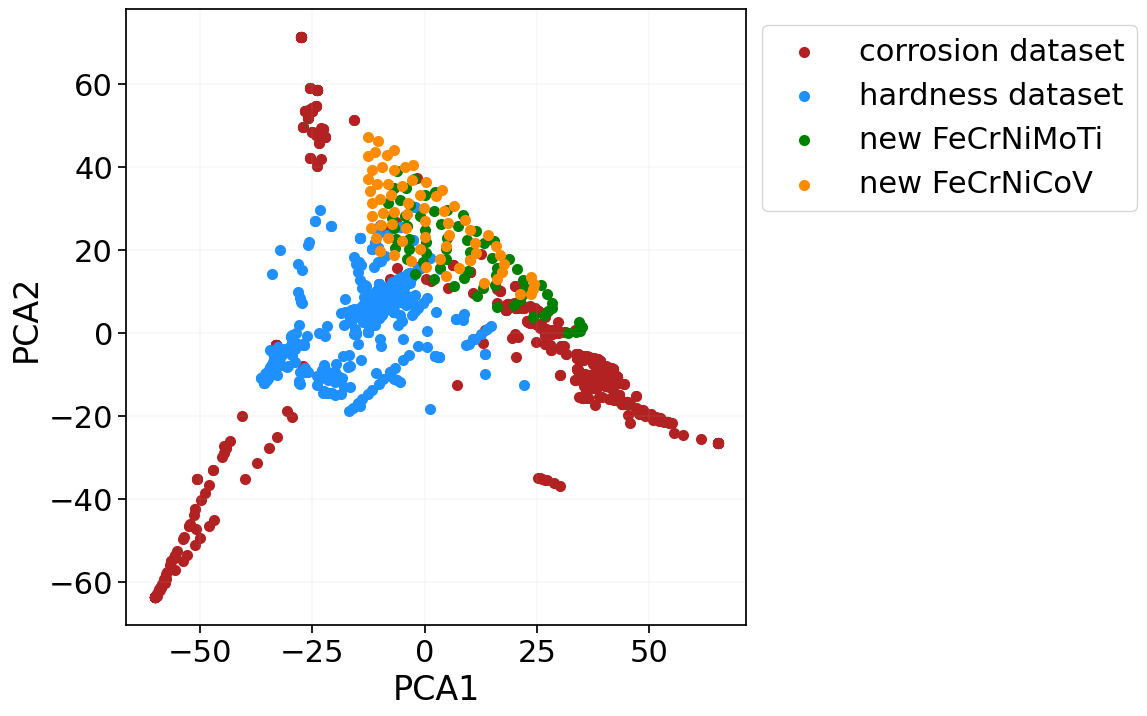

In [11]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Prepare the dataset for PCA
df_conc_new_pca = df_conc_new.copy()

# Map the "dataset" column to numerical values
dataset_mapping = {"corrosion dataset": 0, "hardness dataset": 1, "new FeCrNiMoTi": 2, "new FeCrNiCoV": 3}
df_conc_new_pca["dataset"] = df_conc_new_pca["dataset"].map(dataset_mapping)

# Partition the data
X_conc = df_conc_new_pca.drop(columns='dataset').values  # Feature matrix
y_conc = df_conc_new_pca['dataset'].values  # Target array

# 2D PCA
pca = PCA(n_components=2)
X_conc_r = pca.fit_transform(X_conc)

# Print explained variance ratio
print(f"Explained variance ratio (first two components): {pca.explained_variance_ratio_}")

# plot the projection of PCA analysis
plt.figure(figsize=(8, 8))
colors = ["firebrick", "dodgerblue", "green", "darkorange"]
dataset_names = ["corrosion dataset", "hardness dataset", "new FeCrNiMoTi", "new FeCrNiCoV"]

for color, i, dataset_name in zip(colors, range(len(dataset_names)), dataset_names):
    plt.scatter(X_conc_r[y_conc == i, 0], X_conc_r[y_conc == i, 1], color=color, alpha=1, lw=2, label=dataset_name)

plt.grid(linewidth=0.1)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(loc="upper left", bbox_to_anchor=(1,1), scatterpoints=1)

plt.savefig('PCA 2D_literature+new.png', bbox_inches='tight')
plt.show()


## Let's try to use the concept of outlier/novelty detection (e.g. using Mahalanobis distance)

### Approach Multivariate Outliers and Mahalanobis Distance (simple approach)
https://www.geeksforgeeks.org/how-to-calculate-mahalanobis-distance-in-python/
https://www.machinelearningplus.com/statistics/mahalanobis-distance/ 
https://scikit-learn.org/stable/modules/outlier_detection.html


In [9]:
import scipy.stats as stats
from scipy.stats import chi2
import numpy as np

# Function to calculate the Mahalanobis distance of each point to the "center" of the dataset 
def calculateMahalanobis(y=None, data=None, cov=None):
    # Compute the Mahalanobis Distance between each row of y and the data  
    # y    : matrix of data with, say, p columns (new observation).
    # data : ndarray of the distribution (existing data), from which Mahalanobis distance of each observation of y is to be computed.
    # cov  : covariance matrix (p x p) of the distribution(existing data). If None, will be computed from data.
   
    y_mu = y - np.mean(data)
    if cov is None:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left = np.dot(y_mu, inv_covmat)
    mahal = np.dot(left, y_mu.T)
    return mahal.diagonal()


In [13]:
# prepare the df for calculating Mahalanobis distance (cannot have string in df)
display(df_H_compo.head(1), 
        df_C_compo.head(1), 
        df_compo_new_FeCrNiMoTi.head(1), 
        df_compo_new_FeCrNiCoV.head(1))

 
def process_Mahal_df(df):
    df_num = df.loc[:, df.columns != 'dataset']
    df_label = df[['dataset']]
    return df_num, df_label
    
    
    
 
# only the "training" data (WITHOUT "new" data)
df_H_num, df_H_label = process_Mahal_df(df_H_compo)
df_C_num, df_C_label = process_Mahal_df(df_C_compo)
df_new_FeCrNiMoTi_num, df_new_FeCrNiMoTi_label = process_Mahal_df(df_compo_new_FeCrNiMoTi)


 




,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,Cu,Al,V,Ta,Ti,Co,Mg,Y,dataset
0,69.77,18.0,10.0,0.0,0.0,0.0,0.0,0.03,1.0,1.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,corrosion dataset


,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,...,Al,V,Ta,Ti,Co,Mg,Y,Zr,Hf,dataset
0,19.92,18.54,20.93,0.0,0.0,0,0.0,0.0,0.0,19.59,...,0.0,0.0,0.0,0.0,21.02,0,0.0,0.0,0.0,hardness dataset


,Fe,Cr,Ni,Mo,Ti,dataset
0,14.316994,35.210247,45.453038,4.138939,0.880782,new FeCrNiMoTi


,Fe,Cr,Ni,Co,V,dataset
0,10.271486,31.290494,51.985556,4.851446,1.601018,new FeCrNiCoV


In [ ]:

# double check our training+testing dataset
display(df_training_pca.shape, df_training_pca.head(1))
display(df_new_pca.shape,      df_new_pca.head(1))
display(df_conc_pca.shape,     df_conc_pca.head(1), df_conc_pca.tail(1))

# only the "training" data (WITHOUT "new" data)
df_training_num   = df_training_pca.loc[:, df_training_pca.columns != 'dataset']
df_training_label = df_training_pca[['dataset']]

# only the "new" data 
df_new_num   = df_new_pca.loc[:, df_new_pca.columns != 'dataset']
df_new_label = df_new_pca[['dataset']]
 
# both the "training" data + "new" data
df_conc_num   = df_conc_pca.loc[:, df_conc_pca.columns != 'dataset']
df_conc_label = df_conc_pca[['dataset']]

print(df_conc_num.columns)
print(df_conc_label.columns)


### drop the zero_columns

In [ ]:

# Create an empty list to store the names of the columns containing only zeros
zero_columns = []

# Iterate over each column in the dataframe
for column in df_conc_num.columns:
    # Check if every value in the column is equal to zero
    if (df_conc_num[column] == 0).all():
        # If every value in the column is zero, add the column name to the list
        zero_columns.append(column)

# Print the names of the columns containing only zeros
print(zero_columns)


df_training_num.drop(zero_columns, axis=1, inplace=True)
df_new_num.drop(zero_columns, axis=1, inplace=True)
df_conc_num.drop(zero_columns, axis=1, inplace=True)

# df_training_num.to_excel("checkcheck.xlsx")  
display(df_training_num.head(1))


['N', 'Mg']


/Users/ywu/opt/anaconda3/envs/tf-env/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Fe,Cr,Ni,Mo,W,Nb,C,Si,Mn,Cu,Al,V,Ta,Ti,Co,Y,Zr,Hf
0,19.92,18.54,20.93,0.0,0.0,0.0,0.0,0.0,19.59,0.0,0.0,0.0,0.0,0.0,21.02,0.0,0.0,0.0


### Now let's try two different ways to evaluate the Mahalanobis distance: 
1. - y: the "new" data 
   - data: "traininng" data
   - this will generate Mahalanobis distance only for the "new" data
   - effectively characterise the distance of "new" data to the center of the existing "training" data

In [ ]:
# Creating a new column in the dataframe that holds
# the Mahalanobis distance for each row
df_new_num_Mahal = df_new_num.copy()

df_new_num_Mahal['Mahalanobis'] = calculateMahalanobis(
    y   = df_new_num, 
    data= df_training_num)


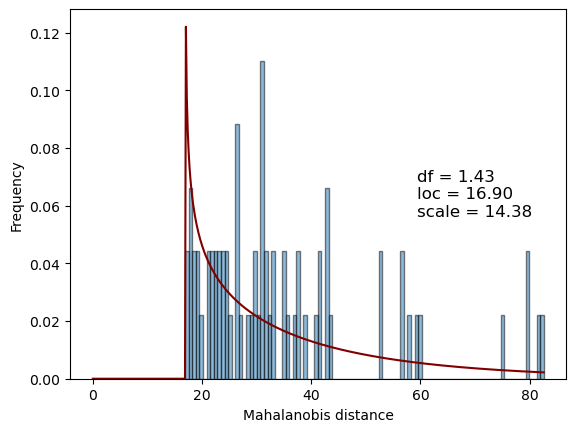

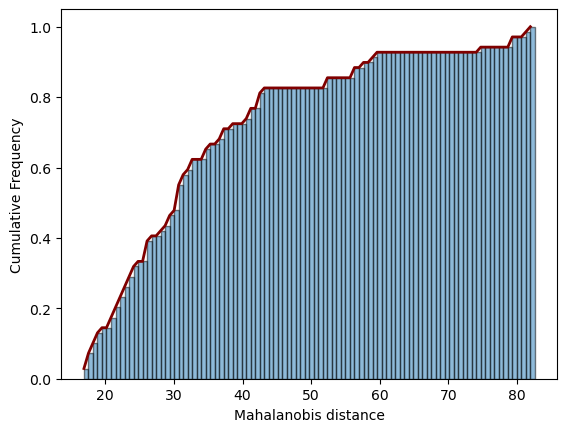

In [ ]:
# -------------------------------------------------------------------- 
# here plot the Mahalanobis distance histogram
plt.hist(df_new_num_Mahal['Mahalanobis'], bins=100, edgecolor='black', alpha=0.5, density=True)
plt.xlabel('Mahalanobis distance')
plt.ylabel('Frequency')
# plt.show()
 
# Fit a chi-squared distribution to the data
df, loc, scale = stats.chi2.fit(df_new_num_Mahal['Mahalanobis'])

# Plot the fitted distribution over the histogram
x_chi2 = np.linspace(0, np.amax(df_new_num_Mahal['Mahalanobis']), 500)
pdf_chi2 = stats.chi2.pdf(x_chi2, df=df, loc=loc, scale=scale)
plt.plot(x_chi2, pdf_chi2, 'maroon')

# Add the fitted values to the plot
plt.text(0.7, 0.5, f"df = {df:.2f}\nloc = {loc:.2f}\nscale = {scale:.2f}",
         transform=plt.gca().transAxes, ha='left', va='center', fontsize=12)
# Show the plot
plt.show()
# -------------------------------------------------------------------- 


# -------------------------------------------------------------------- 
# Plot the histogram
counts, bins, patches = plt.hist(df_new_num_Mahal['Mahalanobis'], 
                                 bins=100, edgecolor='black', alpha=0.5, 
                                 cumulative=True, density=True)
# Plot the CDF
plt.plot(bins[:-1], counts, 'maroon', lw=2)
plt.xlabel('Mahalanobis distance')
plt.ylabel('Cumulative Frequency')
# plt.xlim(0, 100)
plt.show()
# -------------------------------------------------------------------- 




2. - y: the "concanacate" data 
   - data: also the "concanacate" data 
   - this will generate Mahalanobis distance for all the "training+new"
   - we can see all the data points: the "similarity" level all together
   - we will map this "similarity" back to the PCA 2D projection

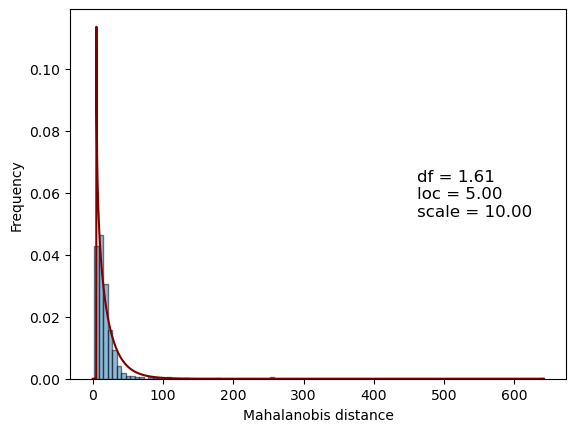

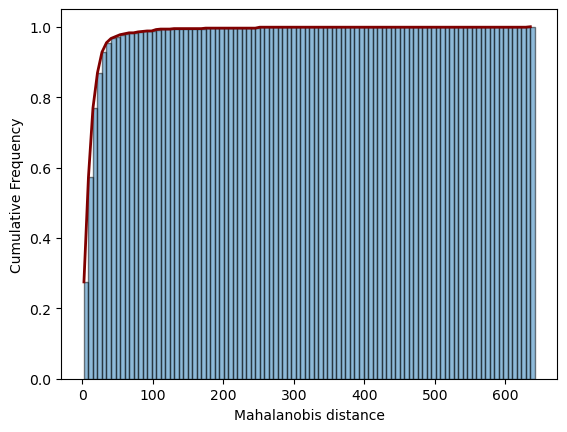

In [ ]:
# Creating a new column in the dataframe that holds
# the Mahalanobis distance for each row
df_conc_num_Mahal = df_conc_num.copy()
df_conc_num_Mahal['Mahalanobis'] = calculateMahalanobis(
    y   = df_conc_num, 
    data= df_conc_num)

# -------------------------------------------------------------------- 
# here plot the Mahalanobis distance histogram
plt.hist(df_conc_num_Mahal['Mahalanobis'], bins=100, edgecolor='black', alpha=0.5, density=True)
plt.xlabel('Mahalanobis distance')
plt.ylabel('Frequency')
# plt.show()
 
# Fit a chi-squared distribution to the data
df, loc, scale = stats.chi2.fit(df_conc_num_Mahal['Mahalanobis'],floc=5, fscale=10)

# Plot the fitted distribution over the histogram
x_chi2 = np.linspace(0, np.amax(df_conc_num_Mahal['Mahalanobis']), 2000)
pdf_chi2 = stats.chi2.pdf(x_chi2, df=df, loc=loc, scale=scale)
plt.plot(x_chi2, pdf_chi2, 'maroon')

# Add the fitted values to the plot
plt.text(0.7, 0.5, f"df = {df:.2f}\nloc = {loc:.2f}\nscale = {scale:.2f}",
         transform=plt.gca().transAxes, ha='left', va='center', fontsize=12)
# plt.xlim(0, 100)
plt.show()
# -------------------------------------------------------------------- 


# -------------------------------------------------------------------- 
# Plot the histogram
counts, bins, patches = plt.hist(df_conc_num_Mahal['Mahalanobis'], 
                                 bins=100, edgecolor='black', alpha=0.5, 
                                 cumulative=True, density=True)
# Plot the CDF
plt.plot(bins[:-1], counts, 'maroon', lw=2)
plt.xlabel('Mahalanobis distance')
plt.ylabel('Cumulative Frequency')
# plt.xlim(0, 100)
plt.show()
# -------------------------------------------------------------------- 

3. let's try chi2 statistics to get a more presentable number: p-value based on chi2 distribution with degree of freedom = 2
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4381501/

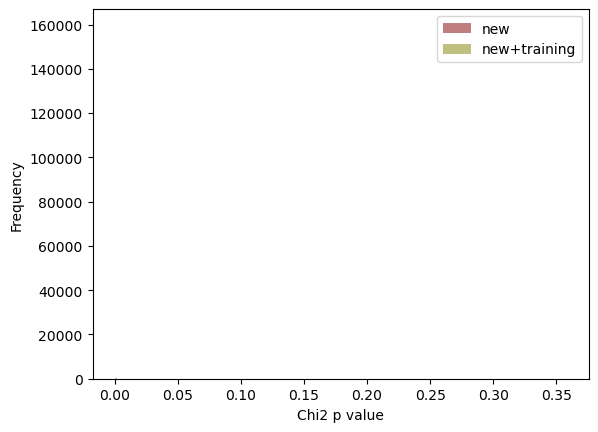

In [ ]:
# calculate p-value for each mahalanobis distance using 
df_new_num_Mahal['p value'] = 1 - chi2.cdf(df_new_num_Mahal['Mahalanobis'], 2)
df_conc_num_Mahal['p value'] = 1 - chi2.cdf(df_conc_num_Mahal['Mahalanobis'], 2)
# Generally, the observation having a p-value less than 0.001 is assumed to be an outlier. 

# a quick look of the chi2 p value distribution
plt.hist(df_new_num_Mahal['p value'], bins=50, color='maroon', alpha=0.5, density=True, label='new')
plt.hist(df_conc_num_Mahal['p value'], bins=200, color='olive', alpha=0.5, density=True, label='new+training')
plt.xlabel('Chi2 p value')
plt.ylabel('Frequency')
plt.legend()
plt.show()
 

In [ ]:
# now re-attach the label
df_new_Mahal  = pd.concat([df_new_num_Mahal,  df_new_label], axis=1)
df_conc_Mahal = pd.concat([df_conc_num_Mahal, df_conc_label], axis=1)
print(df_new_Mahal.tail(3))

# "df_conc_Mahal" is from method 2 to evalute the Mahalanobis distance when including all data
# only select the "new" dataset from the overall "training+new"
df_conc_Mahal_new = df_conc_Mahal[df_conc_Mahal["dataset"]== 1 ]
print(df_conc_Mahal_new.tail(3))


           Fe        Cr         Ni        Mo  W  Nb  C  Si  Mn  Cu  ...  V  \
66  66.296083  4.432613  24.914375  2.416459  0   0  0   0   0   0  ...  0   
67  65.324524  4.818151  24.401985  2.839441  0   0  0   0   0   0  ...  0   
68  63.370312  5.076982  23.439965  4.034033  0   0  0   0   0   0  ...  0   

    Ta        Ti  Co  Y  Zr  Hf  Mahalanobis  p value  dataset  
66   0  1.940470   0  0   0   0    81.877694      0.0        1  
67   0  2.615900   0  0   0   0    79.408629      0.0        1  
68   0  4.078709   0  0   0   0    74.861103      0.0        1  

[3 rows x 21 columns]
           Fe        Cr         Ni        Mo    W   Nb    C   Si   Mn   Cu  \
66  66.296083  4.432613  24.914375  2.416459  0.0  0.0  0.0  0.0  0.0  0.0   
67  65.324524  4.818151  24.401985  2.839441  0.0  0.0  0.0  0.0  0.0  0.0   
68  63.370312  5.076982  23.439965  4.034033  0.0  0.0  0.0  0.0  0.0  0.0   

    ...    V   Ta        Ti   Co    Y   Zr   Hf  Mahalanobis       p value  \
66  ...  0.0 

### If we believe the p value from chi2 statistics can be a measure of "novelty" (smaller ones are more likely outliers), we plot it back to PCA 2D project and also wafer representation

1. map the chi2 pvalues to the PCA 2D projection: it seems the variation of p value is NOT monotonic on this 2D projection 
I mainly highlighted the "new" dataset (you can still see the translucent "training" data points)

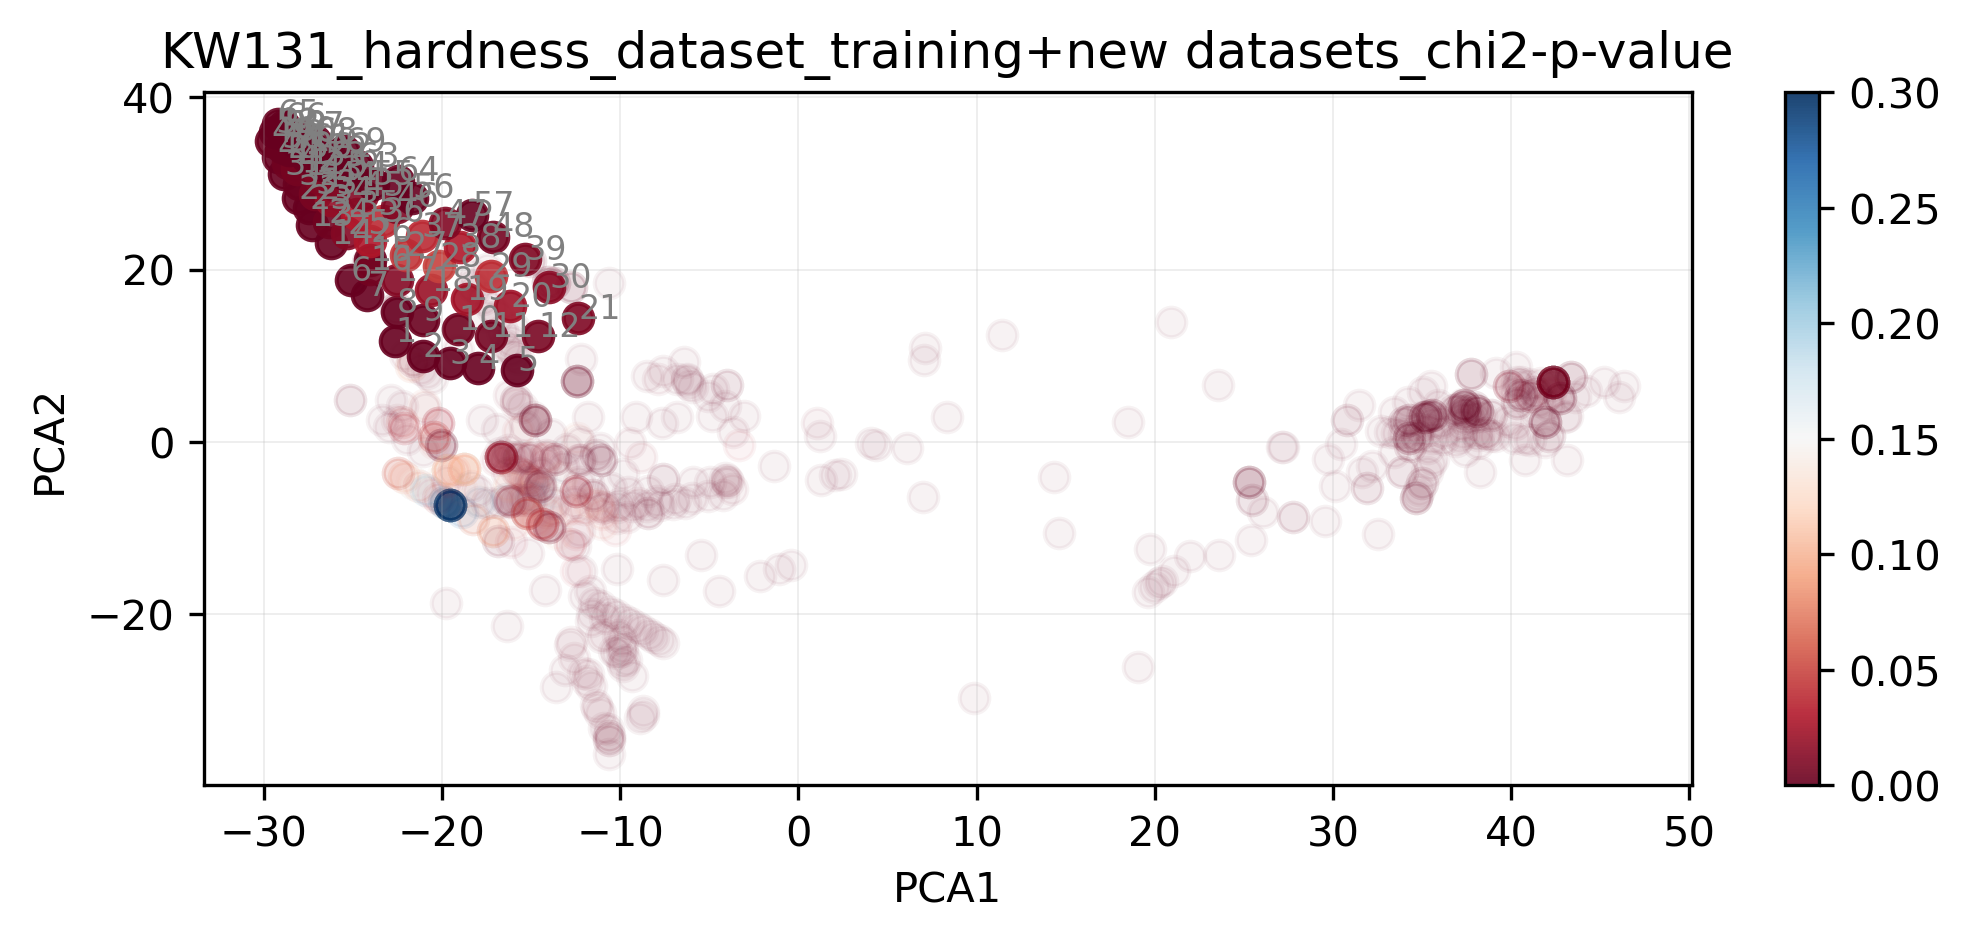

In [ ]:
# plot the projection of PCA analysis
figure(figsize=(8, 3), dpi=300)
# colors = ["navy", "turquoise"]
# lw = 2
z_df_conc_Mahal = df_conc_Mahal["p value"].to_numpy(dtype=float)

for i, value in enumerate(df_conc_Mahal["dataset"].values):
    if value == 0: # means the training data
        plt.scatter(X_conc_r[i,0], X_conc_r[i,1], c=z_df_conc_Mahal[i], s=200, marker='.', alpha=0.05, cmap='RdBu',vmin=0, vmax=0.3)
    if value == 1: # means the new data
        plt.scatter(X_conc_r[i,0], X_conc_r[i,1], c=z_df_conc_Mahal[i], s=200, marker='.', alpha=0.9, cmap='RdBu',vmin=0, vmax=0.3)
        plt.annotate(index_conc[i], (X_conc_r[i, 0], X_conc_r[i, 1]), color="grey", alpha=1, fontsize=8)
        
if PT_name == 'corrosion_PT1':
    plt.xlim([-30, 20])
    plt.ylim([-10, 60])
if PT_name == 'hardness_PT3':
    plt.xlim([10, 50])
    plt.ylim([-10, 15])
 
plt.grid(linewidth = 0.1)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.colorbar()
plt.title(KW_name+'_'+PT_name+'_training+new datasets_chi2-p-value')
# plt.savefig(KW_name+'_'+PT_name+'_2D PCA_training+new_zoomin_pValue.png', bbox_inches='tight')
plt.show()
 

Now I will plot the p value on the wafer 

In [ ]:
# load the wafer-coordinates
PVD_x_y = pd.read_excel(data_path + 'PVD_x_y.xlsx');

coord_x = PVD_x_y["x"].to_numpy(dtype=float)
coord_y = PVD_x_y["y"].to_numpy(dtype=float)

z_KW_conc_Mahal_new = df_conc_Mahal_new["p value"].to_numpy(dtype=float)
z_KW_new_Mahal      = df_new_Mahal["p value"].to_numpy(dtype=float)
 
# prepare as the labels: 1-69
index_conc_Mahal_new = df_conc_Mahal_new.index.values + 1
 


I will also fix the level of color contours: because maybe the rational way here when selecting compositions is selecting a few ranges: close->intermediate->far from the center of the data group

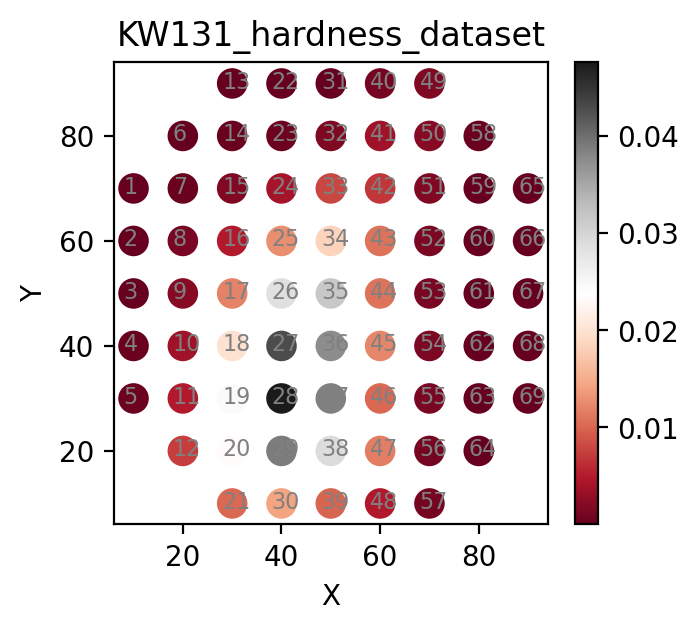

In [ ]:
# Create the scatter contour plot BEFORE regulation

figure(figsize=(3.5, 3), dpi=200)
cax1 = plt.scatter(coord_x, coord_y, c=z_KW_conc_Mahal_new, s=400, marker='.', cmap='RdGy') # ,vmin=0.2, vmax=0.6 RdBu/RdGy
plt.xlabel('X')
plt.ylabel('Y')
plt.title(KW_name+'_'+PT_name)

for i, txt in enumerate(index_conc_Mahal_new):
    plt.annotate(txt, (coord_x[i]-2, coord_y[i]-1), color="grey", alpha=1, fontsize=8)

plt.colorbar(cax1)
plt.savefig(KW_name+'_'+PT_name+'_Mahalanobis_pValue.png', bbox_inches='tight')
plt.show()


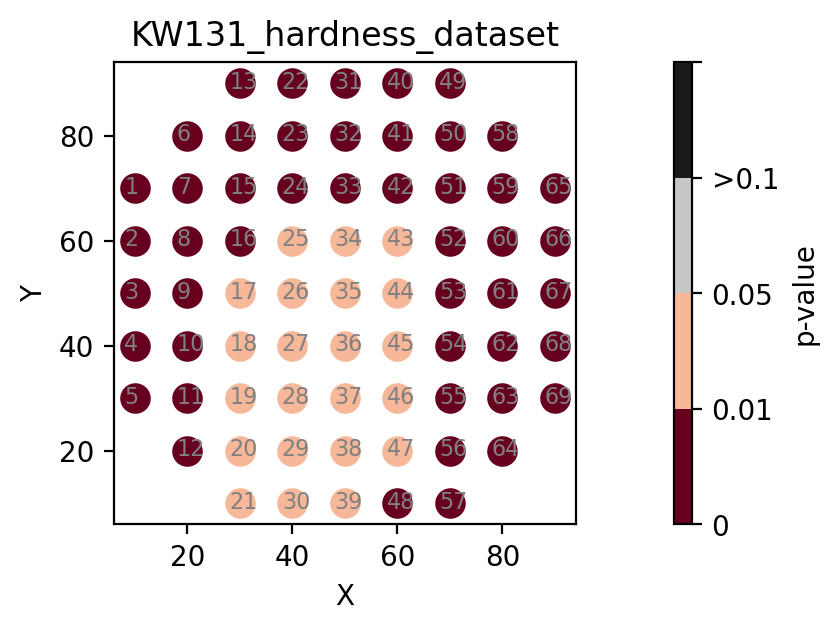

In [ ]:
# Create the scatter contour plot AFTER regulation

fig, (ax1, ax2) = plt.subplots(figsize = (4, 3),
                          ncols = 2, gridspec_kw={'width_ratios': [3, 0.1]}, dpi=200)

# plot the fixed intervals 
cmap = cm.RdGy(np.linspace(0, 1, 4))  # RdBu/RdGy
 
c_0_01     = [i for i,v in enumerate(z_KW_conc_Mahal_new) if v < 0.01]
c_0_05    = [i for i,v in enumerate(z_KW_conc_Mahal_new) if v < 0.05 and v >= 0.01]
c_0_1     = [i for i,v in enumerate(z_KW_conc_Mahal_new) if v < 0.1  and v >= 0.05]
c_abv_0_1 = [i for i,v in enumerate(z_KW_conc_Mahal_new) if              v >= 0.1]

cax1 = ax1.scatter(coord_x[c_0_01],    coord_y[c_0_01],    color=cmap[0], s=400, marker='.') # ,vmin=0.2, vmax=0.6
cax2 = ax1.scatter(coord_x[c_0_05],    coord_y[c_0_05],    color=cmap[1], s=400, marker='.') # ,vmin=0.2, vmax=0.6
cax3 = ax1.scatter(coord_x[c_0_1],     coord_y[c_0_1],     color=cmap[2], s=400, marker='.') # ,vmin=0.2, vmax=0.6
cax4 = ax1.scatter(coord_x[c_abv_0_1], coord_y[c_abv_0_1], color=cmap[3], s=400, marker='.') # ,vmin=0.2, vmax=0.6

ax1.set_aspect('equal', 'box')
for i, txt in enumerate(index_conc_Mahal_new):
    ax1.annotate(txt, (coord_x[i]-2, coord_y[i]-1), color="grey", alpha=1, fontsize=8)
 
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title(KW_name+'_'+PT_name) 


# customised colorbar: https://matplotlib.org/stable/tutorials/colors/colorbar_only.html

cmap = mpl.cm.RdGy  #RdBu/RdGy
bounds = [0, 1, 2, 3, 4]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax2, orientation='vertical',  
             label="p-value")
cbar.ax.set_yticklabels(['0','0.01','0.05','>0.1',''])

  
plt.savefig(KW_name+'_'+PT_name+'_Mahalanobis_pValue_reg.png', bbox_inches='tight')
plt.show()

let's also plot the Mahalanobis distance to "center" of the data (only use the training data)

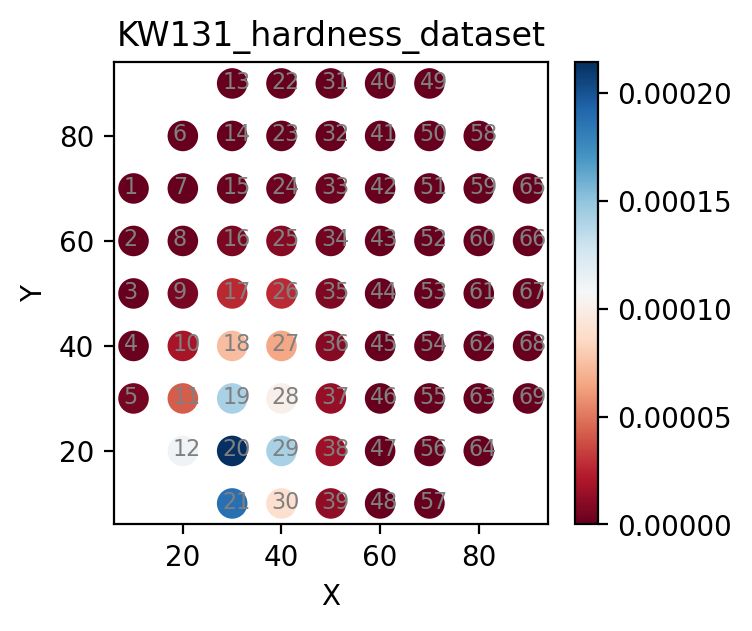

In [ ]:
# Create the scatter contour plot BEFORE regulation
figure(figsize=(3.5, 3), dpi=200)
cax1 = plt.scatter(coord_x, coord_y, c=z_KW_new_Mahal, s=400, marker='.', cmap='RdBu') # ,vmin=0.2, vmax=0.6
plt.xlabel('X')
plt.ylabel('Y')
plt.title(KW_name+'_'+PT_name)

for i, txt in enumerate(index_conc_Mahal_new):
    plt.annotate(txt, (coord_x[i]-2, coord_y[i]-1), color="grey", alpha=1, fontsize=8)

plt.colorbar(cax1)
# plt.savefig(KW_name+'_'+PT_name+'_Mahalanobis_pValue_lean.png', bbox_inches='tight')
plt.show()
 

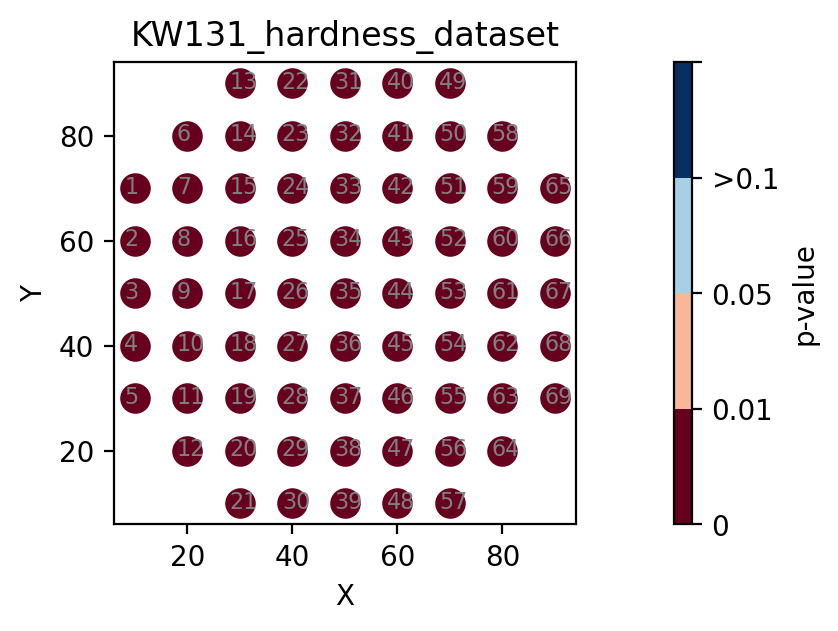

In [ ]:
# Create the scatter contour plot AFTER regulation

fig, (ax1, ax2) = plt.subplots(figsize = (4, 3),
                          ncols = 2, gridspec_kw={'width_ratios': [3, 0.1]}, dpi=200)

# plot the fixed intervals
cmap = cm.RdBu(np.linspace(0, 1, 4))
 
c_0_01    = [i for i,v in enumerate(z_KW_new_Mahal) if v < 0.01]
c_0_05    = [i for i,v in enumerate(z_KW_new_Mahal) if v < 0.05 and v >= 0.01]
c_0_1     = [i for i,v in enumerate(z_KW_new_Mahal) if v < 0.1  and v >= 0.05]
c_abv_0_1 = [i for i,v in enumerate(z_KW_new_Mahal) if              v >= 0.1]

cax1 = ax1.scatter(coord_x[c_0_01],    coord_y[c_0_01],    color=cmap[0], s=400, marker='.') # ,vmin=0.2, vmax=0.6
cax2 = ax1.scatter(coord_x[c_0_05],    coord_y[c_0_05],    color=cmap[1], s=400, marker='.') # ,vmin=0.2, vmax=0.6
cax3 = ax1.scatter(coord_x[c_0_1],     coord_y[c_0_1],     color=cmap[2], s=400, marker='.') # ,vmin=0.2, vmax=0.6
cax4 = ax1.scatter(coord_x[c_abv_0_1], coord_y[c_abv_0_1], color=cmap[3], s=400, marker='.') # ,vmin=0.2, vmax=0.6

ax1.set_aspect('equal', 'box')
for i, txt in enumerate(index_conc_Mahal_new):
    ax1.annotate(txt, (coord_x[i]-2, coord_y[i]-1), color="grey", alpha=1, fontsize=8)
 
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title(KW_name+'_'+PT_name) 


# customised colorbar: https://matplotlib.org/stable/tutorials/colors/colorbar_only.html

cmap = mpl.cm.RdBu
bounds = [0, 1, 2, 3, 4]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax2, orientation='vertical',  
             label="p-value")
cbar.ax.set_yticklabels(['0','0.01','0.05','>0.1',''])

  
# plt.savefig(KW_name+'_'+PT_name+'_Mahalanobis_pValue_lean_reg.png', bbox_inches='tight')
plt.show()

In [ ]:
# # figure(figsize=(3.5, 3), dpi=200)

# fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize = (14, 3),
#                                     ncols = 4)

# # c_0_01 = [i for i,v in enumerate(z_KW_conc_Mahal_new) if v <0.01]
# # z_KW_conc_Mahal_new[c_0_01] = 0.01
# range1 = ax1.scatter(coord_x, coord_y, c=z_KW_conc_Mahal_new, s=400, marker='.', cmap='Greys_r',vmin=0.00, vmax=0.025) # ,vmin=0.2, vmax=0.6
# ax1.set_aspect('equal', 'box')
# for i, txt in enumerate(index_conc_Mahal_new):
#     ax1.annotate(txt, (coord_x[i]-2, coord_y[i]-1), color="grey", alpha=1, fontsize=8)
# fig.colorbar(range1, ax = ax1)

# range2 = ax2.scatter(coord_x, coord_y, c=z_KW_conc_Mahal_new, s=400, marker='.', cmap='Blues_r',vmin=0.025, vmax=0.05) # ,vmin=0.2, vmax=0.6
# ax2.set_aspect('equal', 'box')
# for i, txt in enumerate(index_conc_Mahal_new):
#     ax2.annotate(txt, (coord_x[i]-2, coord_y[i]-1), color="grey", alpha=1, fontsize=8)
# fig.colorbar(range2, ax = ax2)

# range3 = ax3.scatter(coord_x, coord_y, c=z_KW_conc_Mahal_new, s=400, marker='.', cmap='Greens_r',vmin=0.05, vmax=0.1) # ,vmin=0.2, vmax=0.6
# ax3.set_aspect('equal', 'box')
# for i, txt in enumerate(index_conc_Mahal_new):
#     ax3.annotate(txt, (coord_x[i]-2, coord_y[i]-1), color="grey", alpha=1, fontsize=8)
# fig.colorbar(range3, ax = ax3)

# range4 = ax4.scatter(coord_x, coord_y, c=z_KW_conc_Mahal_new, s=400, marker='.', cmap='coolwarm_r',vmin=0.1) # ,vmin=0.2, vmax=0.6
# ax4.set_aspect('equal', 'box')
# for i, txt in enumerate(index_conc_Mahal_new):
#     ax4.annotate(txt, (coord_x[i]-2, coord_y[i]-1), color="grey", alpha=1, fontsize=8)
# fig.colorbar(range4, ax = ax4)

# # cax1 = plt.scatter(coord_x, coord_y, c=z_KW_conc_Mahal_new, s=400, marker='.', cmap='RdBu',vmin=0.05) # ,vmin=0.2, vmax=0.6
# # plt.xlabel('X')
# # plt.ylabel('Y')
# # plt.title(KW_name)

# for i, txt in enumerate(index_conc_Mahal_new):
#     ax1.annotate(txt, (coord_x[i]-2, coord_y[i]-1), color="grey", alpha=1, fontsize=8)

# # plt.colorbar(cax1)
# plt.savefig(KW_name+'_Mahalanobis_pValue_corrosion_PT1.png', bbox_inches='tight')
# plt.show()
 
 

In [ ]:
# z_KW_conc_Mahal_new_reg = np.empty((len(z_KW_conc_Mahal_new)))

# # Here we catogrise the p values into 4 level
# # cbar_ticks = np.linspace(np.nanmin(z_KW_conc_Mahal_new), np.nanmax(z_KW_conc_Mahal_new), 9)
# cbar_ticks = np.array([0, 0.025, 0.05, 0.1, 0.9])

# # for i, z in enumerate(z_KW_conc_Mahal_new):
# #     if z >= cbar_ticks[0] and z <= cbar_ticks[2]:
# #         z_KW_conc_Mahal_new_reg[i] = cbar_ticks[1]
# #     if z >= cbar_ticks[2] and z <= cbar_ticks[4]:
# #         z_KW_conc_Mahal_new_reg[i] = cbar_ticks[3]
# #     if z >= cbar_ticks[4] and z <= cbar_ticks[6]:
# #         z_KW_conc_Mahal_new_reg[i] = cbar_ticks[5]
# #     if z >= cbar_ticks[6] and z <= cbar_ticks[8]:
# #         z_KW_conc_Mahal_new_reg[i] = cbar_ticks[7]

# for i, z in enumerate(z_KW_conc_Mahal_new):
#     if z >= cbar_ticks[0] and z <= cbar_ticks[1]:
#         z_KW_conc_Mahal_new_reg[i] = (cbar_ticks[0]+cbar_ticks[1])/2
#     if z >= cbar_ticks[1] and z <= cbar_ticks[2]:
#         z_KW_conc_Mahal_new_reg[i] = (cbar_ticks[1]+cbar_ticks[2])/2
#     if z >= cbar_ticks[2] and z <= cbar_ticks[3]:
#         z_KW_conc_Mahal_new_reg[i] = (cbar_ticks[2]+cbar_ticks[3])/2
#     if z >= cbar_ticks[3] and z <= cbar_ticks[4]:
#         z_KW_conc_Mahal_new_reg[i] = (cbar_ticks[3]+cbar_ticks[4])/2
 

# # print(x, x.dtype, x.shape)
# # print(y, y.dtype, y.shape)
# # print(z_KW99, z_KW99.dtype, z_KW99.shape)